<h1><center><b>ChemistrAI</b></center></h1>

# **Context**

I will train this model deterministically using standard backpropagation techniques and stochastically by maximizing a variational minor tied. 
I will also show through visualization how the model is capable of automatically learning to fix its look at highlighted objects while generating the corresponding words in the output stream

It is a combination of convolutional neural networks to obtain the vector representation of images and recurrent neural networks to decode those representations into natural language sentences.

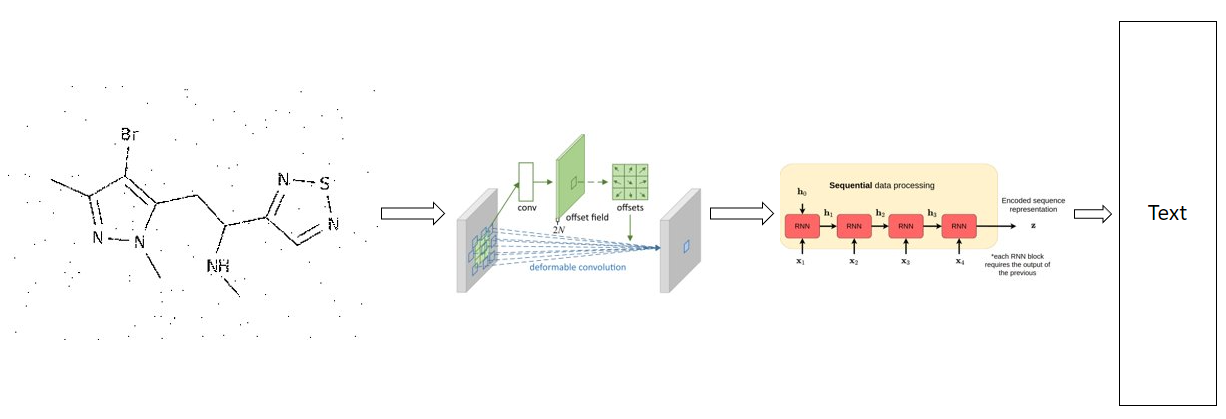

In [ ]:
# Libraries

import os
from matplotlib import pyplot as plt

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
import numpy as np
import pandas as pd
import torch

import sys
sys.path.append('/timm-pytorch-image-models/pytorch-image-models-master')

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import Levenshtein #Metric in training
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **EfficientNet**

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients. 

For example, if we want to use 2ⁿ times more computational resources, then we can simply increase the network depth by αⁿ, width by βⁿ, and image size by γⁿ, where α,β,γ are constant coefficients determined by a small grid search on the original small model. EfficientNet uses a compound coefficient ϕ to uniformly scales network width, depth, and resolution in a principled way.

The compound scaling method is justified by the intuition that if the input image is bigger, then the network needs more layers to increase the receptive field and more channels to capture more fine-grained patterns on the bigger image.

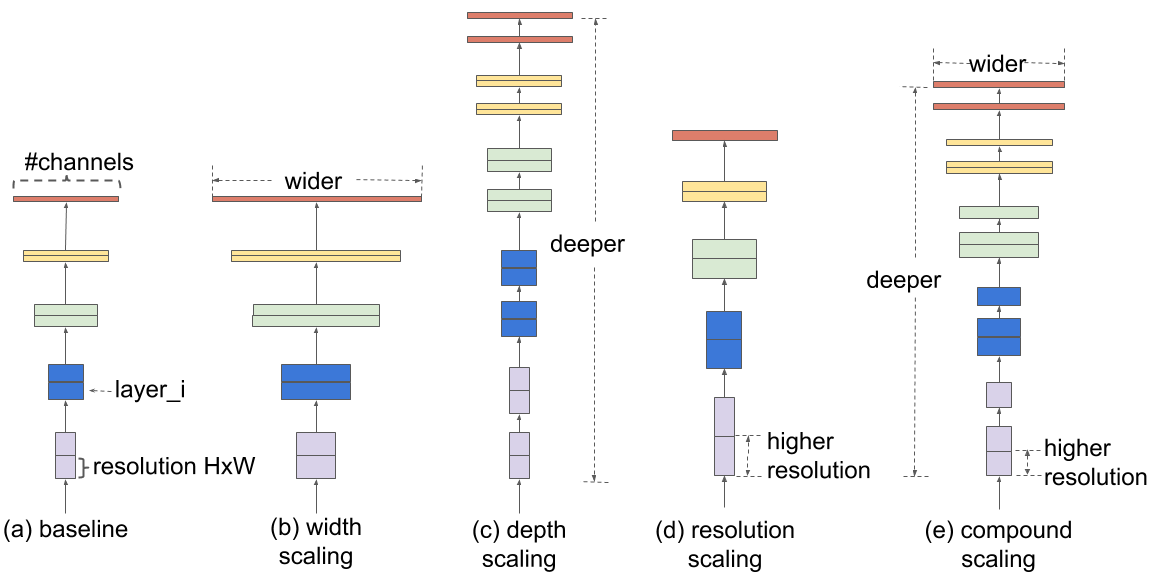

Configuration

In [ ]:
class CFG:
    debug          = True
    apex           = False
    max_len        = 275
    print_freq     = 250
    num_workers    = 4
    model_name     = 'efficientnet_b2'
    enc_size       = 1408
    samp_size      = 100000
    size           = 288
    scheduler      = 'CosineAnnealingLR' 
    epochs         = 1 
    T_max          = 4  
    encoder_lr     = 1e-4
    decoder_lr     = 4e-4
    min_lr         = 1e-6
    batch_size     = 32
    weight_decay   = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm  = 10
    attention_dim  = 256
    embed_dim      = 512
    decoder_dim    = 512
    decoder_layers = 2     # number of LSTM layers
    dropout        = 0.5
    seed           = 42
    n_fold         = 5
    trn_fold       = 0 
    train          = True
    train_path     = '/wowdao-generative-ai-applications-dataset/data/train/'
    prep_path      = '/tokenizer-and-preprocessing-of-chemical-formulas/'

# **Tokenizer**

The tokenizer developed in the previous part of this project

In [ ]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load(CFG.prep_path + 'tokenizer.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

# **Metric for evaluation (Levenshtein distance)**

It is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. 

Levenshtein distance may also be referred to as edit distance, although that term may also denote a larger family of distance metrics known collectively as edit distance.It is closely related to pairwise string alignments.

For example, the Levenshtein distance between "kitten" and "sitting" is 3, since the following 3 edits change one into the other, and there is no way to do it with fewer than 3 edits:

* kitten → sitten (substitution of "s" for "k"),
* sitten → sittin (substitution of "i" for "e"),
* sittin → sitting (insertion of "g" at the end).

In [ ]:
#Metric in training
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

#Fix the random seed
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.seed)

In [ ]:
# Datasets transformers to convert the image files to tensors (arrays) and tokenize the InChI texts

# The training dataset will contain 
# * the image (array)
# * tokenized  InChI texts
# * lengh of tokenized InChI texts
class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        super().__init__()
        self.df         = df
        self.tokenizer  = tokenizer
        self.file_paths = df['file_path'].values
        self.labels     = df['InChI_text'].values
        self.transform  = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transform:
            augmented = self.transform(image = image)
            image     = augmented['image']
        label = self.labels[idx]
        label = self.tokenizer.text_to_sequence(label)
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        return image, torch.LongTensor(label), label_length
    
# The testing dataset will contain 
# * the image (array)
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.file_paths = df['file_path'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [ ]:
#Concatenates a sequence of tensors along a new dimension
#All tensors will be of the same size
def bms_collate(batch):
    imgs, labels, label_lengths = [], [], []
    for data_point in batch:
        imgs.append(data_point[0])
        labels.append(data_point[1])
        label_lengths.append(data_point[2])
    labels = pad_sequence(labels, batch_first = True, padding_value = tokenizer.stoi["<pad>"])
    return torch.stack(imgs), labels, torch.stack(label_lengths).reshape(-1, 1)

# **CNN Encoder**

In [ ]:
#CNN Encoder

class Encoder(nn.Module):
    def __init__(self, model_name = CFG.model_name, pretrained = False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)

    def forward(self, x):
        bs       = x.size(0)
        features = self.cnn.forward_features(x)
        features = features.permute(0, 2, 3, 1)
        return features

# **RNN Decoder**

In [ ]:
#RNN Decoder

# Attention
class Attention(nn.Module):
    '''
    Attention network for calculate attention value
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        '''
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        '''
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att    = nn.Linear(attention_dim, 1)            # linear layer to calculate values to be softmax-ed
        self.relu        = nn.ReLU()
        self.softmax     = nn.Softmax(dim = 1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1  = self.encoder_att(encoder_out)     # (batch_size, num_pixels, attention_dim)
        att2  = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att   = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                 # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
    
#Custom LSTM cell
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m

# Decoder
class DecoderWithAttention(nn.Module):
    '''
    Decoder network with attention network used for training
    '''
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        '''
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param num_layers: number of the LSTM layers
        :param dropout: dropout rate
        '''
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune = True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim = 1)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, None

# **Helper functions**

In [ ]:
# Helper functions
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val   = 0
        self.avg   = 0
        self.sum   = 0
        self.count = 0

    def update(self, val, n=1):
        self.val    = val
        self.sum   += val * n
        self.count += n
        self.avg    = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s   = now - since
    es  = s / (percent)
    rs  = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, encoder, decoder, criterion,encoder_optimizer, decoder_optimizer,epoch,encoder_scheduler, decoder_scheduler, device):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()
    # Switch to train mode
    encoder.train()
    decoder.train()
    start = end = time.time()
    global_step = 0
    
    for step, (images, labels, label_lengths) in enumerate(train_loader):    
        # Measure data loading time
        data_time.update(time.time() - end)

        images        = images.to(device)
        labels        = labels.to(device)
        label_lengths = label_lengths.to(device)
        batch_size    = images.size(0)
    
        features = encoder(images)
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets     = caps_sorted[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets     = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        loss        = criterion(predictions, targets)
        
        # Record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, decoder_optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        encoder_grad_norm = torch.nn.utils.clip_grad_norm_(encoder.parameters(), CFG.max_grad_norm)
        decoder_grad_norm = torch.nn.utils.clip_grad_norm_(decoder.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            encoder_optimizer.step()
            decoder_optimizer.step()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            global_step += 1
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Encoder Grad: {encoder_grad_norm:.4f}  '
                  'Decoder Grad: {decoder_grad_norm:.4f}  '
                  #'Encoder LR: {encoder_lr:.6f}  '
                  #'Decoder LR: {decoder_lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), 
                   batch_time        = batch_time,
                   data_time         = data_time, 
                   loss              = losses,
                   remain            = timeSince(start, float(step+1)/len(train_loader)),
                   encoder_grad_norm = encoder_grad_norm,
                   decoder_grad_norm = decoder_grad_norm,
                   #encoder_lr=encoder_scheduler.get_lr()[0],
                   #decoder_lr=decoder_scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    # Switch to evaluation mode
    encoder.eval()
    decoder.eval()
    text_preds = []
    start = end = time.time()
    for step, (images) in enumerate(valid_loader):
        # Measure data loading time
        data_time.update(time.time() - end)
        images     = images.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            features    = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer) 
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  .format(
                      step, 
                      len(valid_loader),
                      batch_time = batch_time,
                      data_time = data_time,
                      remain = timeSince(start, float(step+1)/len(valid_loader)),
                  ))
    text_preds = np.concatenate(text_preds)
    return text_preds

# **Training function**

In [ ]:
# Train loop

def train_loop(folds, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")
    # Loader
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds  = folds.loc[trn_idx].reset_index(drop = True)
    valid_folds  = folds.loc[val_idx].reset_index(drop = True)
    valid_labels = valid_folds['InChI'].values

    train_dataset = TrainDataset(train_folds, tokenizer, transform = get_transforms(data = 'train'))
    valid_dataset = TestDataset(valid_folds, transform = get_transforms(data = 'valid'))

    train_loader = DataLoader(train_dataset,batch_size = CFG.batch_size,shuffle = True,num_workers = CFG.num_workers,pin_memory = True,
                              drop_last = True, collate_fn  = bms_collate)
    valid_loader = DataLoader(valid_dataset,batch_size  = CFG.batch_size, shuffle = False, num_workers = CFG.num_workers,pin_memory  = True, 
                              drop_last = False)
    
    # Scheduler 
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, 
                                          mode     = 'min', 
                                          factor   = CFG.factor, 
                                          patience = CFG.patience, 
                                          verbose  = True, 
                                          eps      = CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, 
                                          T_max      = CFG.T_max, 
                                          eta_min    = CFG.min_lr, 
                                          last_epoch = -1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                                    T_0        = CFG.T_0, 
                                                    T_mult     = 1, 
                                                    eta_min    = CFG.min_lr, 
                                                    last_epoch = -1)
        return scheduler

    # Model & optimizer
    encoder = Encoder(CFG.model_name, pretrained = True)
    encoder.to(device)
    encoder_optimizer = Adam(encoder.parameters(),lr = CFG.encoder_lr,weight_decay = CFG.weight_decay, amsgrad = False)
    encoder_scheduler = get_scheduler(encoder_optimizer)
    decoder = DecoderWithAttention(attention_dim = CFG.attention_dim, 
                                   embed_dim     = CFG.embed_dim, 
                                   encoder_dim   = CFG.enc_size,
                                   decoder_dim   = CFG.decoder_dim,
                                   num_layers    = CFG.decoder_layers,
                                   vocab_size    = len(tokenizer), 
                                   dropout       = CFG.dropout, 
                                   device        = device)
    decoder.to(device)
    decoder_optimizer = Adam(decoder.parameters(), lr = CFG.decoder_lr, weight_decay = CFG.weight_decay, amsgrad = False)
    decoder_scheduler = get_scheduler(decoder_optimizer)

    # Loop
    criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.stoi["<pad>"])
    best_score = np.inf
    best_loss  = np.inf
    for epoch in range(CFG.epochs):
        start_time = time.time()
        # Train
        avg_loss = train_fn(train_loader, encoder, decoder, criterion,encoder_optimizer, decoder_optimizer, epoch,encoder_scheduler, decoder_scheduler, device)
        # Evaluation
        text_preds = valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device)
        text_preds = [f"InChI=1S/{text}" for text in text_preds]
        LOGGER.info(f"labels: {valid_labels[:5]}")
        LOGGER.info(f"preds: {text_preds[:5]}")
        # Scoring
        score = get_score(valid_labels, text_preds)
        if isinstance(encoder_scheduler, ReduceLROnPlateau):
            encoder_scheduler.step(score)
        elif isinstance(encoder_scheduler, CosineAnnealingLR):
            encoder_scheduler.step()
        elif isinstance(encoder_scheduler, CosineAnnealingWarmRestarts):
            encoder_scheduler.step()
            
        if isinstance(decoder_scheduler, ReduceLROnPlateau):
            decoder_scheduler.step(score)
        elif isinstance(decoder_scheduler, CosineAnnealingLR):
            decoder_scheduler.step()
        elif isinstance(decoder_scheduler, CosineAnnealingWarmRestarts):
            decoder_scheduler.step()

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'encoder': encoder.state_dict(), 
                        'encoder_optimizer': encoder_optimizer.state_dict(), 
                        'encoder_scheduler': encoder_scheduler.state_dict(), 
                        'decoder': decoder.state_dict(), 
                        'decoder_optimizer': decoder_optimizer.state_dict(), 
                        'decoder_scheduler': decoder_scheduler.state_dict(), 
                        'text_preds': text_preds,
                       },
                        OUTPUT_DIR+'best_model.pth')

In [ ]:
def get_train_file_path(image_id):
    return CFG.train_path + "{}/{}/{}/{}.png".format(image_id[0], image_id[1], image_id[2], image_id )

In [ ]:
# Transformations

def get_transforms(*, data):
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            HorizontalFlip(p=0.5),                  
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),   
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# **Training**

In [ ]:
train = pd.read_pickle(CFG.prep_path + 'train.pkl')
train['file_path'] = train['image_id'].apply(get_train_file_path)
print("Training dataset:")
display(train.head())

if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n = CFG.samp_size, random_state = CFG.seed).reset_index(drop = True)

Training dataset:


,image_id,InChI,InChI_1,InChI_text,InChI_length,file_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59,../input/wowdao-generative-ai-applications-dat...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108,../input/wowdao-generative-ai-applications-dat...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112,../input/wowdao-generative-ai-applications-dat...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108,../input/wowdao-generative-ai-applications-dat...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72,../input/wowdao-generative-ai-applications-dat...


In [ ]:
train_dataset = TrainDataset(train, tokenizer, transform = get_transforms(data='train'))
folds = train.copy()
Fold = StratifiedKFold(n_splits = CFG.n_fold, shuffle = True, random_state = CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print("Folds dataset:")
display(folds.head())

Folds dataset:


,image_id,InChI,InChI_1,InChI_text,InChI_length,file_path,fold
0,8200059001fe,InChI=1S/C21H22N6O4/c1-10-19-14(27-21(22)24-10...,C21H22N6O4,C 21 H 22 N 6 O 4 /c 1 - 10 - 19 - 14 ( 27 - 2...,124,../input/wowdao-generative-ai-applications-dat...,3
1,58c5db73d7f8,InChI=1S/C28H34O4/c1-4-25(31)10-7-21-8-12-27(2...,C28H34O4,C 28 H 34 O 4 /c 1 - 4 - 25 ( 31 ) 10 - 7 - 21...,113,../input/wowdao-generative-ai-applications-dat...,0
2,00959a2eb183,InChI=1S/C21H26N2O4S/c1-27-19-12-10-17(11-13-1...,C21H26N2O4S,C 21 H 26 N 2 O 4 S /c 1 - 27 - 19 - 12 - 10 -...,111,../input/wowdao-generative-ai-applications-dat...,3
3,8cbf75bf235f,InChI=1S/C16H14FN3O/c17-13-6-7-14(15(19)10-13)...,C16H14FN3O,C 16 H 14 F N 3 O /c 17 - 13 - 6 - 7 - 14 ( 15...,69,../input/wowdao-generative-ai-applications-dat...,0
4,d7a2ebeea3e0,InChI=1S/C14H14ClN3O/c1-9-8-12(18-17-9)13(19)1...,C14H14ClN3O,C 14 H 14 Cl N 3 O /c 1 - 9 - 8 - 12 ( 18 - 17...,84,../input/wowdao-generative-ai-applications-dat...,2


In [ ]:
train_loop(folds, CFG.trn_fold)

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


Epoch: [1][0/2500] Data 1.398 (1.398) Elapsed 0m 7s (remain 317m 20s) Loss: 5.2970(5.2970) Encoder Grad: 1.3135  Decoder Grad: 0.8952  
Epoch: [1][250/2500] Data 0.001 (0.006) Elapsed 3m 24s (remain 30m 34s) Loss: 1.8493(2.4307) Encoder Grad: 0.5453  Decoder Grad: 0.5375  
Epoch: [1][500/2500] Data 0.000 (0.003) Elapsed 6m 41s (remain 26m 42s) Loss: 1.5170(2.0252) Encoder Grad: 0.2347  Decoder Grad: 0.3790  
Epoch: [1][750/2500] Data 0.000 (0.002) Elapsed 9m 57s (remain 23m 11s) Loss: 1.4499(1.8476) Encoder Grad: 0.3315  Decoder Grad: 0.4234  
Epoch: [1][1000/2500] Data 0.000 (0.002) Elapsed 13m 15s (remain 19m 51s) Loss: 1.4152(1.7346) Encoder Grad: 0.2994  Decoder Grad: 0.3282  
Epoch: [1][1250/2500] Data 0.000 (0.002) Elapsed 16m 36s (remain 16m 34s) Loss: 1.2867(1.6505) Encoder Grad: 0.3618  Decoder Grad: 0.4281  
Epoch: [1][1500/2500] Data 0.000 (0.001) Elapsed 20m 0s (remain 13m 19s) Loss: 1.1648(1.5835) Encoder Grad: 0.2449  Decoder Grad: 0.3862  
Epoch: [1][1750/2500] Data 0.00

labels: ['InChI=1S/C28H34O4/c1-4-25(31)10-7-21-8-12-27(20(3)13-21)28-15-26(11-5-19(28)2)32-18-22-6-9-23(16-29)24(14-22)17-30/h5-6,8-9,11-15,25,29-31H,4,7,10,16-18H2,1-3H3'
 'InChI=1S/C16H14FN3O/c17-13-6-7-14(15(19)10-13)16(21)20(9-8-18)11-12-4-2-1-3-5-12/h1-7,10H,9,11,19H2'
 'InChI=1S/C25H23N3O2S/c1-16(2)15-28-23(21-11-6-12-31-21)22(19-9-3-4-10-20(19)25(28)30)24(29)27-18-8-5-7-17(13-18)14-26/h3-13,16,22-23H,15H2,1-2H3,(H,27,29)'
 'InChI=1S/C14H20N2O3/c1-3-4-7-16(9-13(15)18)14(19)12-6-5-11(17)8-10(12)2/h5-6,8,17H,3-4,7,9H2,1-2H3,(H2,15,18)'
 'InChI=1S/C12H24N2O/c1-8(2)10-5-4-6-11(7-10)14-9(3)12(13)15/h8-11,14H,4-7H2,1-3H3,(H2,13,15)']
preds: ['InChI=1S/C30H36NO3/c1-4-5-7-21-8-10-24(13-17-27)23-9-10-23(11-12-25)23-9-10-23(2)14-20(3)27(27)27(29)27(29)27(29)29/h5-9,14-16,21,25,29,33H,4-5,11-15,20H2,1-3H3', 'InChI=1S/C15H14FN3O/c16-13-5-1-2-8-14(11)18-11-16(19)18-9-10-19(18)14-5-3-4-6-15(14)18/h1-8,12,18H,9-10H2', 'InChI=1S/C25H25N2O3S/c1-15(2)24-21(27)13-23(27)26-19-9-5-7-17(19)12-22(25)26